In [2]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from DepthData_mob import DepthDataset
from DepthData_mob import Augmentation
from DepthData_mob import ToTensor

In [4]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('./data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)


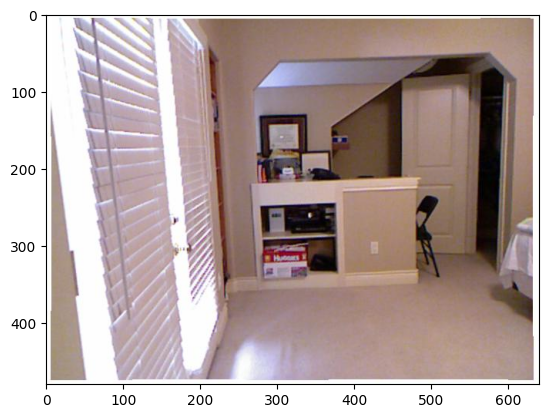

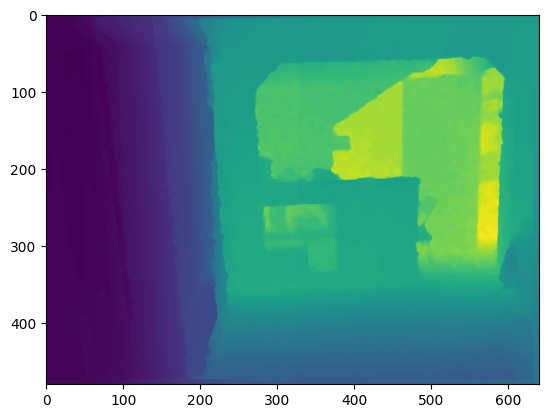

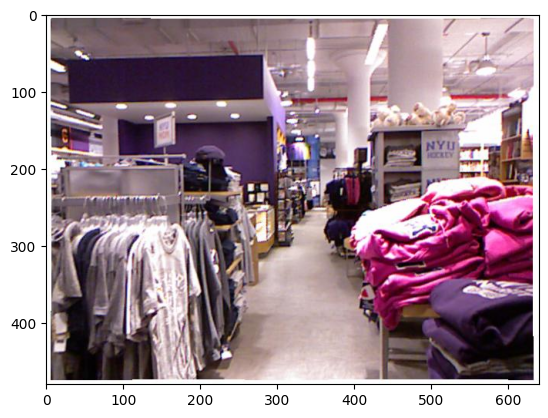

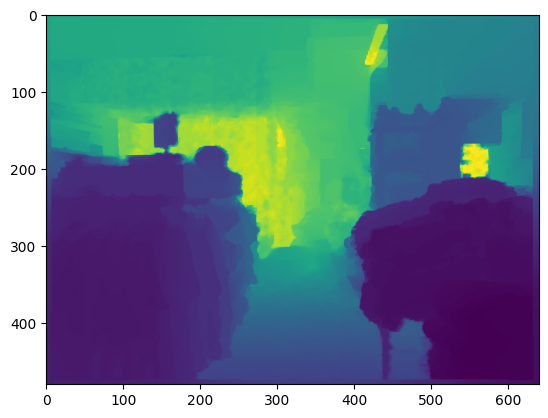

<Figure size 640x480 with 0 Axes>

In [5]:
#display a sample set of image and depth image
depth_dataset = DepthDataset(traincsv=traincsv,root_dir='./')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print(i, sample['image'].size, sample['depth'].size)
    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()
    if i == 1:
        plt.show()
        break

In [7]:
#loading the mobilNetDepth model
from Mobile_model import Model

In [8]:
import cv2
import kornia 

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
#     was losses.SSIM
    ssim = kornia.losses.SSIMLoss(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [9]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [10]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [ ]:
# Training

In [24]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
# from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)
#load trained model if needed
#model.load_state_dict(torch.load('/workspace/1.pth'))
print('Model created.')
print(torch.cuda.is_available())


# originally 50
epochs=50
lr=0.0001
# default 64
batch_size=4

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='./',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )

# Start training...
for epoch in range(epochs):
    path='./model/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 10 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='./model/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)    
    

Model created.
True
Epoch: [0][0/12672]	Time 1.104 (1.104)	ETA 3:53:08	Loss 0.7450 (0.7450)
Epoch: [0][10/12672]	Time 0.184 (2.942)	ETA 0:38:50	Loss 0.6896 (0.7241)
Epoch: [0][20/12672]	Time 0.191 (4.771)	ETA 0:40:12	Loss 0.7730 (0.7282)
Epoch: [0][30/12672]	Time 0.193 (6.605)	ETA 0:40:35	Loss 0.6071 (0.7177)
Epoch: [0][40/12672]	Time 0.174 (8.430)	ETA 0:36:35	Loss 0.7765 (0.7030)
Epoch: [0][50/12672]	Time 0.193 (10.275)	ETA 0:40:41	Loss 0.6395 (0.7018)
Epoch: [0][60/12672]	Time 0.192 (12.115)	ETA 0:40:27	Loss 0.6075 (0.6956)
Epoch: [0][70/12672]	Time 0.185 (13.946)	ETA 0:38:47	Loss 0.6747 (0.6915)
Epoch: [0][80/12672]	Time 0.184 (15.796)	ETA 0:38:40	Loss 0.7151 (0.6888)
Epoch: [0][90/12672]	Time 0.184 (17.636)	ETA 0:38:38	Loss 0.7126 (0.6879)
Epoch: [0][100/12672]	Time 0.194 (19.489)	ETA 0:40:39	Loss 0.5828 (0.6824)
Epoch: [0][110/12672]	Time 0.180 (21.328)	ETA 0:37:40	Loss 0.6687 (0.6804)
Epoch: [0][120/12672]	Time 0.191 (23.184)	ETA 0:39:52	Loss 0.6689 (0.6803)
Epoch: [0][130/12672]

KeyboardInterrupt: 

In [ ]:
# Testing

In [28]:
#Evaluations
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils   

model = Model().cuda()
# model = nn.DataParallel(model)
#load the model if needed
model.load_state_dict(torch.load('./model/26.pth'))
model.eval()
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='./',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    print('image')
    print(image1.cpu().numpy().size)
    
    depth = sample_batched1['depth'].numpy()
    print('depth')
    print(depth.size)
    
    outtt=model(image1 )
    break

    

image
921600
depth
76800


1112.2112
109.068474
992.15686
105.882355
377.30905
115.505806
376.47058
109.803925
579.2513
85.27327
568.6275
82.35294
441.67776
69.262215
545.0981
70.58824
1025.1979
212.09686
996.0784
200.0


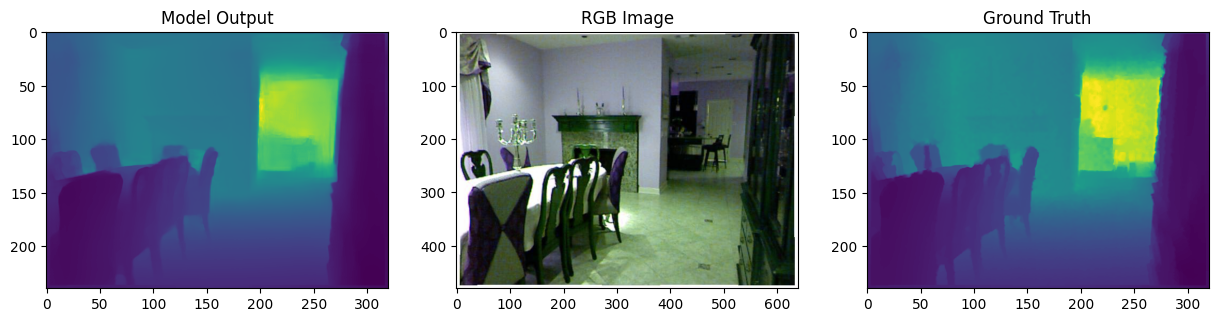

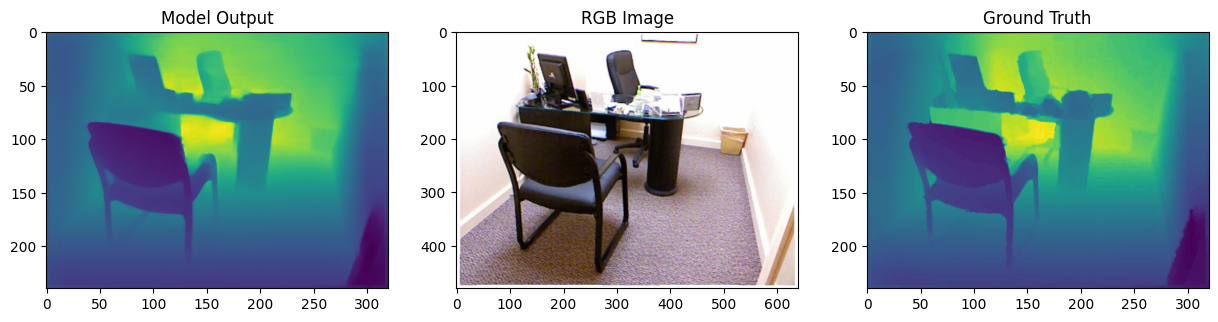

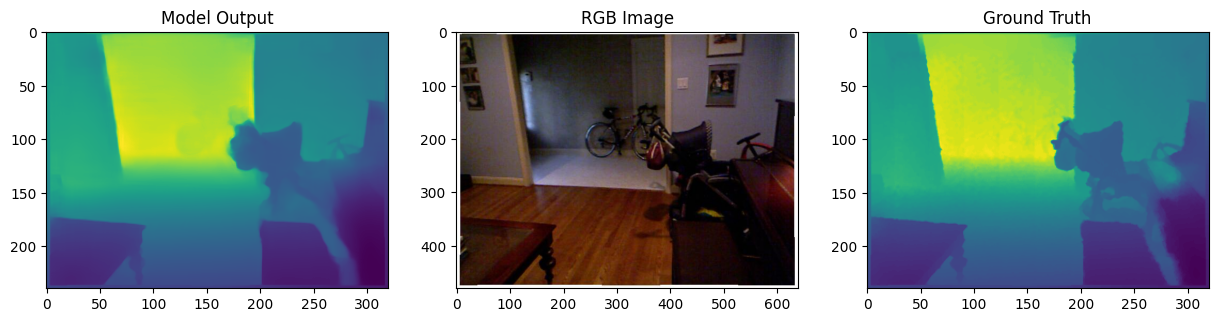

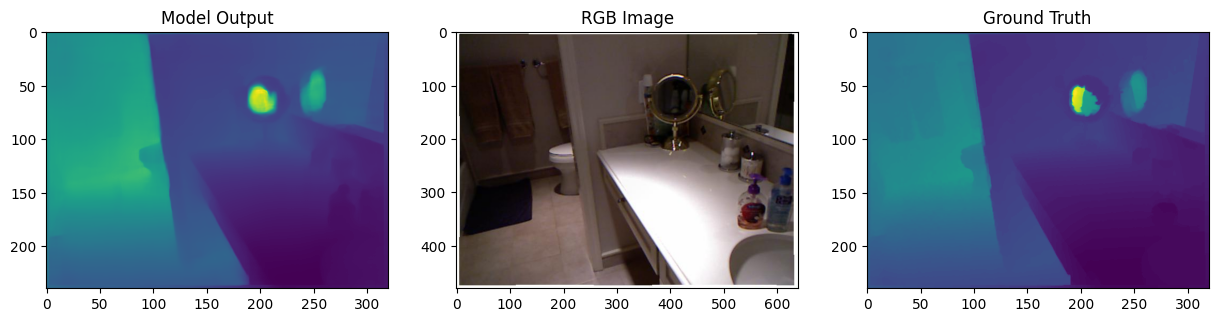

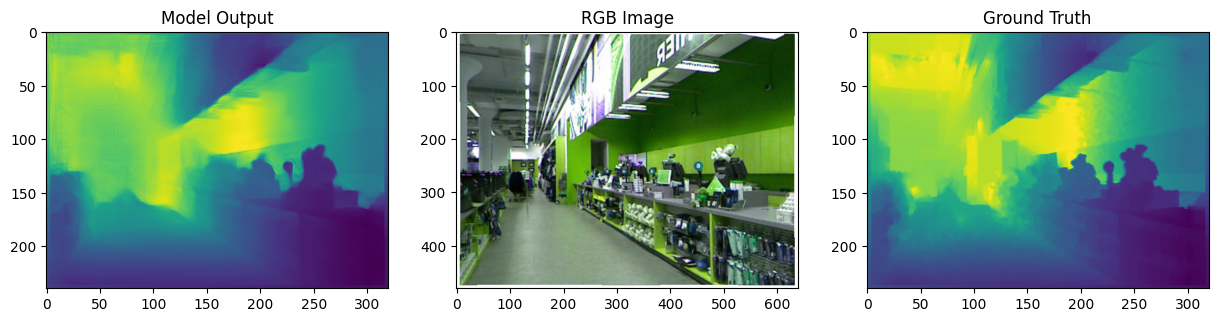

In [29]:
depth_dataset = DepthDataset(traincsv=traincsv, root_dir='./',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

count = 5

for sample_batched1  in (train_loader):
    if count == 0:
        break
    
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    outtt=model(image1)
    #ploting the evaluated images from training set
    x=outtt.detach().cpu().numpy()
    x.shape
    x=x.reshape(240,320,1)
    
    x = 1000/x
    
    gnd_truth = sample_batched1['depth'].detach().cpu().numpy().reshape(1,240,320).transpose(1,2,0)
    rgb = sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 7.5))
    
    axes[0].imshow(x)
    axes[0].set_title('Model Output')
    axes[1].imshow(rgb)
    axes[1].set_title('RGB Image')
    axes[2].imshow(gnd_truth)
    axes[2].set_title('Ground Truth')
    fig.show()

    # print(x)
    print(max(x.flatten()))
    print(min(x.flatten()))
    

    # print(gnd_truth)
    print(max(gnd_truth.flatten()))
    print(min(gnd_truth.flatten()))
    count -= 1